# Read data and exploration

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [59]:
customer = pd.read_csv("Customers.csv")
comment = pd.read_csv("Comments.csv")

In [60]:
customer.isnull().sum()

ID                      0
Sex                     0
Status                  0
Children                0
Est_Income              0
Car_Owner               0
Usage                   0
Age                     0
RatePlan                0
LongDistance            0
International           0
Local                   0
Dropped                 0
Paymethod               0
LocalBilltype           0
LongDistanceBilltype    0
TARGET                  0
dtype: int64

In [61]:
customer

,ID,Sex,Status,Children,Est_Income,Car_Owner,Usage,Age,RatePlan,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,TARGET
0,1,F,S,1,38000.00,N,229.64,24.393333,3,23.56,0.00,206.08,0,CC,Budget,Intnl_discount,Cancelled
1,6,M,M,2,29616.00,N,75.29,49.426667,2,29.78,0.00,45.50,0,CH,FreeLocal,Standard,Current
2,8,M,M,0,19732.80,N,47.25,50.673333,3,24.81,0.00,22.44,0,CC,FreeLocal,Standard,Current
3,11,M,S,2,96.33,N,59.01,56.473333,1,26.13,0.00,32.88,1,CC,Budget,Standard,Current
4,14,F,M,2,52004.80,N,28.14,25.140000,1,5.03,0.00,23.11,0,CH,Budget,Intnl_discount,Cancelled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,3821,F,S,0,78851.30,N,29.04,48.373333,4,0.37,0.00,28.66,0,CC,FreeLocal,Standard,Cancelled
2066,3822,F,S,1,17540.70,Y,36.20,62.786667,1,22.17,0.57,13.45,0,Auto,Budget,Standard,Cancelled
2067,3823,F,M,0,83891.90,Y,74.40,61.020000,4,28.92,0.00,45.47,0,CH,Budget,Standard,Cancelled
2068,3824,F,M,2,28220.80,N,38.95,38.766667,4,26.49,0.00,12.46,0,CC,FreeLocal,Standard,Cancelled


In [62]:
comment.sort_values(by=["ID"],inplace=True)

In [63]:
customer = pd.merge(customer,comment,how="inner",on=["ID"])

In [64]:
customer.dtypes

ID                        int64
Sex                      object
Status                   object
Children                  int64
Est_Income              float64
Car_Owner                object
Usage                   float64
Age                     float64
RatePlan                  int64
LongDistance            float64
International           float64
Local                   float64
Dropped                   int64
Paymethod                object
LocalBilltype            object
LongDistanceBilltype     object
TARGET                   object
Comments                 object
dtype: object

In [65]:
customer.Comments.head(3)

0    Asked about how to change his ring tones. Refe...
1    Needs help learning how to use the phone. I su...
2    Needs help learning how to use the phone. I su...
Name: Comments, dtype: object

In [66]:
print(customer.shape, comment.shape)

(2070, 18) (2070, 2)


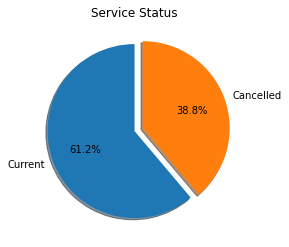

In [67]:
label = ["Current","Cancelled"]
explode = (0, 0.1) 
size = (1266,804)
plt.pie(size,explode=explode,labels=label,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Service Status")
plt.show()

In [89]:
print(customer.subjectivity[customer.TARGET==0].mean())
print(customer.subjectivity[customer.TARGET==1].mean())

0.18905856974504395
0.18574208504743653


# Encode the categorical variables in the customer table

In [68]:
from sklearn.preprocessing import LabelEncoder

In [69]:
col = customer.select_dtypes(include=object)
col_names = col.columns
print(col_names)

Index(['Sex', 'Status', 'Car_Owner', 'Paymethod', 'LocalBilltype',
       'LongDistanceBilltype', 'TARGET', 'Comments'],
      dtype='object')


In [70]:
le = LabelEncoder()

In [71]:
for x in col_names:
  customer[x]=le.fit(customer[x]).transform(customer[x])

# Base score with Xgboost & Random Forest

In [72]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [73]:
customer_x = customer.drop(["ID","TARGET"],axis=1)
customer_y = customer.TARGET

In [74]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = XGBClassifier()
rfc = RandomForestClassifier()
scoring1 = 'accuracy'
scoring2 = 'roc_auc'

In [75]:
basescore = cross_val_score(model, customer_x, customer_y, scoring=scoring1, cv=4, n_jobs=-1) 
basescore = basescore.mean()
print(basescore)
basesauc = cross_val_score(model, customer_x, customer_y, scoring=scoring2, cv=4, n_jobs=-1) 
basesauc = basesauc.mean()
print(basesauc)

0.8710204401693764
0.9215922680154314


In [76]:
rfcbasescore = cross_val_score(rfc, customer_x, customer_y, scoring=scoring1, cv=4, n_jobs=-1) 
rfcbasescore = rfcbasescore.mean()
print(rfcbasescore)
rfcbasesauc = cross_val_score(rfc, customer_x, customer_y, scoring=scoring2, cv=4, n_jobs=-1) 
rfcbasesauc = rfcbasesauc.mean()
print(rfcbasesauc)

0.8705387481983227
0.9193214971244484


# TextBlob Sentiment Analysis

In [77]:
from textblob import TextBlob

In [78]:
def find_pol(review):
    return TextBlob(review).sentiment.polarity
def find_sub(review):
    return TextBlob(review).sentiment.subjectivity

In [79]:
print("SENTIMENT POLARITY & SUBJECTIVITY")
customer['sentiment'] = comment['Comments'].apply(find_pol)
customer['subjectivity'] = comment['Comments'].apply(find_sub)

SENTIMENT POLARITY & SUBJECTIVITY


In [80]:
#customer.Comments.unique()
for i in range(0,115):
  value = customer[customer.Comments==i].sentiment
  mean = customer[customer.Comments==i].sentiment.mean()
  std = customer[customer.Comments==i].sentiment.std()
  outliers = (value-mean).abs() > std 
  customer["sentiment"][outliers.index]= mean

In [81]:
for i in range(0,115):
  value = customer[customer.Comments==i].subjectivity
  mean = customer[customer.Comments==i].subjectivity.mean()
  std = customer[customer.Comments==i].subjectivity.std()
  outliers = (value-mean).abs() > std 
  customer["subjectivity"][outliers.index]= mean

In [82]:
customer_x = customer.drop(["ID","TARGET"],axis=1)
customer_y = customer.TARGET

In [83]:
score1 = cross_val_score(model, customer_x, customer_y, scoring=scoring1, cv=cv, n_jobs=-1) 
score1 = score1.mean()
print(score1)
improvement1 = (score1 - basescore)/basescore
print('{:.2%}'.format(improvement1))
auc1 = cross_val_score(model, customer_x, customer_y, scoring=scoring2, cv=cv, n_jobs=-1) 
auc1 = auc1.mean()
print(auc1)
improve_auc1 = (auc1 - basesauc)/basesauc
print('{:.2%}'.format(improve_auc1))

0.8932367149758453
2.55%
0.92905563774798
0.81%


In [84]:
rfcscore1 = cross_val_score(rfc, customer_x, customer_y, scoring=scoring1, cv=cv, n_jobs=-1) 
rfcscore1 = rfcscore1.mean()
print(rfcscore1)
rfcimprovement1 = (rfcscore1 - rfcbasescore)/rfcbasescore
print('{:.2%}'.format(rfcimprovement1))
rfcauc1 = cross_val_score(rfc, customer_x, customer_y, scoring=scoring2, cv=cv, n_jobs=-1) 
rfcauc1 = rfcauc1.mean()
print(rfcauc1)
rfcimprove_auc1 = (rfcauc1 - rfcbasesauc)/rfcbasesauc
print('{:.2%}'.format(rfcimprove_auc1))

0.8888888888888887
2.11%
0.9249043753751671
0.61%


# Sentence Embedding with SBERT

#### load model

In [191]:
pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (1.1.0)


In [192]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('stsb-mpnet-base-v2', 
                                  device='cuda')

#### fit models

In [193]:
sentence_embeddings = sbert_model.encode(comment.Comments)

In [194]:
sentence_embeddings.shape

(2070, 768)

In [195]:
sent_emb = pd.DataFrame(sentence_embeddings).mean(axis=1)
customer["sent_emb"] = sent_emb

In [196]:
#customer.Comments.unique()
for i in range(0,115):
  value = customer[customer.Comments==i].sent_emb
  median = customer[customer.Comments==i].sent_emb.mean()
  std = customer[customer.Comments==i].sent_emb.std()
  outliers = (value-median).abs() > std 
  customer["sent_emb"][outliers.index]= median

In [197]:
customer_x = customer.drop(["ID","TARGET"],axis=1)
customer_y = customer.TARGET

In [198]:
score2 = cross_val_score(model, customer_x, customer_y, scoring=scoring1, cv=cv, n_jobs=-1) 
score2 = score2.mean()
print(score2)
improvement2 = (score2 - basescore)/basescore
print('{:.2%}'.format(improvement2))
auc2 = cross_val_score(model, customer_x, customer_y, scoring=scoring2, cv=cv, n_jobs=-1) 
auc2 = auc2.mean()
print(auc2)
improve_auc2 = (auc2 - basesauc)/basesauc
print('{:.2%}'.format(improve_auc2))

0.8932367149758453
2.55%
0.9313981192153993
1.06%


In [199]:
rfcscore2 = cross_val_score(rfc, customer_x, customer_y, scoring=scoring1, cv=cv, n_jobs=-1) 
rfcscore2 = rfcscore2.mean()
print(rfcscore2)
rfcimprovement2 = (rfcscore2 - rfcbasescore)/rfcbasescore
print('{:.2%}'.format(rfcimprovement2))
rfcauc2 = cross_val_score(rfc, customer_x, customer_y, scoring=scoring2, cv=cv, n_jobs=-1) 
rfcauc2 = rfcauc2.mean()
print(rfcauc2)
rfcimprove_auc2 = (rfcauc2 - rfcbasesauc)/rfcbasesauc
print('{:.2%}'.format(rfcimprove_auc2))

0.8879227053140095
1.66%
0.9239947777335376
0.32%


In [200]:
print(len(customer.Comments.value_counts()),len(customer.sent_emb.value_counts()))

115 113


# TFIDF

## Clean text

In [201]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import string
from textblob import Word
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [202]:
df = comment
df["patterns"] = df.Comments

In [203]:
stop = stopwords.words('english')
df['patterns'] = df['patterns'].apply(lambda x:' '.join(x.lower() for x in x.split()))
df['patterns'] = df['patterns'].apply(lambda x:' '.join(x for x in x.split() if x not in string.punctuation)) #remove punctuations
df['patterns'] = df['patterns'].str.replace('https*\S+','')  #remove url
df['patterns'] = df['patterns'].str.replace('\'\w+','')      #remove ticks
df['patterns'] = df['patterns'].str.replace('[^\w\s]','')    
df['patterns'] = df['patterns'].str.replace('@\S+','')       #remove email
df['patterns'] = df['patterns'].str.encode('ascii', 'ignore').str.decode("utf-8")  #remove unicode
df['patterns'] = df['patterns'].str.replace('\w*\d+\w*','')  #remove digits
df['patterns'] = df['patterns'].str.replace('#\S+','')  #remove hashtag
df['patterns'] = df['patterns'].str.replace('_','')  #remove underscore
df['patterns'] = df['patterns'].apply(lambda x: ' '.join(x for x in x.split() if  not x.isdigit()))
df['patterns'] = df['patterns'].apply(lambda x:' '.join(x for x in x.split() if not x in stop)) #remove stop words
df['patterns'] = df['patterns'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [204]:
df["patterns"]

178              asked change ring tone referred web site
951     need help learning use phone suggested go back...
622     need help learning use phone suggested go back...
172     need help learning use phone suggested go back...
1287    need help learning use phone suggested go back...
                              ...                        
1554    said battery never worked well want new phone ...
1424    said battery never worked well want new phone ...
326     said battery never worked well want new phone ...
1229    said battery never worked well want new phone ...
1380    said battery never worked well want new phone ...
Name: patterns, Length: 2070, dtype: object

In [205]:
corpus=[]
for i in df["patterns"]:
    li = i.split()
    corpus.append(li)

## Fit tfidf

In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [207]:
numwords = 0
for i in df["patterns"]:
  numwords += len(i.split())

numwords

18497

In [208]:
feature = []
for i in df["patterns"]:
  feature.append(i.split())
flat_list = [item for items in feature for item in items]
feature=len(set(flat_list))
feature

425

In [209]:
# removing special characters and stop words from the text
#stop_words_l=stopwords.words('english')
import math
max_feature = math.ceil(feature*0.1)
tfidfvectoriser=TfidfVectorizer(strip_accents="ascii",max_features=max_feature,max_df = 0.2)
tfidfvectoriser.fit(df["patterns"])
tfidf_vectors=tfidfvectoriser.transform(df["patterns"])
tfidf_vectors=pd.DataFrame(tfidf_vectors.toarray())
tfidf_vectors.columns = tfidfvectoriser.get_feature_names()

In [210]:
tfidf_vectors

,accessory,additional,asap,asked,back,battery,bill,buy,call,called,care,change,customer,family,get,go,handset,help,learning,line,location,minute,nearest,need,never,new,plan,rate,really,referred,rep,said,service,site,suggested,teach,transferred,use,wanted,web,well,work,worked
0,0.0,0.0,0.000000,0.482439,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.452913,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.435692,0.000000,0.000000,0.0,0.432378,0.000000,0.000000,0.0,0.000000,0.0,0.430516,0.000000,0.0,0.000000
1,0.0,0.0,0.000000,0.000000,0.305806,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333698,0.0,0.301525,0.353846,0.0,0.0,0.0,0.0,0.325704,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.353846,0.000000,0.0,0.000000,0.330258,0.353846,0.0,0.336801,0.0,0.000000,0.000000,0.0,0.000000
2,0.0,0.0,0.000000,0.000000,0.305806,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333698,0.0,0.301525,0.353846,0.0,0.0,0.0,0.0,0.325704,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.353846,0.000000,0.0,0.000000,0.330258,0.353846,0.0,0.336801,0.0,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.000000,0.000000,0.305806,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333698,0.0,0.301525,0.353846,0.0,0.0,0.0,0.0,0.325704,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.353846,0.000000,0.0,0.000000,0.330258,0.353846,0.0,0.336801,0.0,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.000000,0.000000,0.305806,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333698,0.0,0.301525,0.353846,0.0,0.0,0.0,0.0,0.325704,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.353846,0.000000,0.0,0.000000,0.330258,0.353846,0.0,0.336801,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,0.0,0.0,0.388222,0.000000,0.000000,0.369054,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.398448,0.307365,0.0,0.0,0.0,0.000000,0.000000,0.377457,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.390684,0.0,0.405883
2066,0.0,0.0,0.388222,0.000000,0.000000,0.369054,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.398448,0.307365,0.0,0.0,0.0,0.000000,0.000000,0.377457,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.390684,0.0,0.405883
2067,0.0,0.0,0.388222,0.000000,0.000000,0.369054,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.398448,0.307365,0.0,0.0,0.0,0.000000,0.000000,0.377457,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.390684,0.0,0.405883
2068,0.0,0.0,0.388222,0.000000,0.000000,0.369054,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.398448,0.307365,0.0,0.0,0.0,0.000000,0.000000,0.377457,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.390684,0.0,0.405883


In [211]:
customer = pd.merge(customer,tfidf_vectors,left_index=True,right_index=True)

In [212]:
customer_x = customer.drop(["ID","TARGET"],axis=1)
customer_y = customer.TARGET

In [213]:
score3 = cross_val_score(model, customer_x, customer_y, scoring=scoring1, cv=cv, n_jobs=-1) 
score3 = score3.mean()
print(score3)
improvement3 = (score3 - basescore)/basescore
print('{:.2%}'.format(improvement3))
auc3 = cross_val_score(model, customer_x, customer_y, scoring=scoring2, cv=cv, n_jobs=-1) 
auc3 = auc3.mean()
print(auc3)
improve_auc3 = (auc3 - basesauc)/basesauc
print('{:.2%}'.format(improve_auc3))

0.8946859903381641
2.72%
0.9336910293293188
1.31%


In [214]:
rfcscore3 = cross_val_score(rfc, customer_x, customer_y, scoring=scoring1, cv=cv, n_jobs=-1) 
rfcscore3 = rfcscore3.mean()
print(rfcscore3)
rfcimprovement3 = (rfcscore3 - rfcbasescore)/rfcbasescore
print('{:.2%}'.format(rfcimprovement3))
rfcauc3 = cross_val_score(rfc, customer_x, customer_y, scoring=scoring2, cv=cv, n_jobs=-1) 
rfcauc3 = rfcauc3.mean()
print(rfcauc3)
rfcimprove_auc3 = (rfcauc3 - rfcbasesauc)/rfcbasesauc
print('{:.2%}'.format(rfcimprove_auc3))

0.8893719806763285
1.82%
0.9230523843500716
0.22%


# Fine tune the final model

##### install and load bayesian-optimization

In [50]:
pip install bayesian-optimization

In [51]:
import numpy as np
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

##### set up and fit

In [59]:
pbounds = {
    'learning_rate': (0.1, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (10,30),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (3, 7),
    'reg_lambda':(0,1),
    }

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma,
                        reg_lambda):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        reg_lambda=reg_lambda)
    return np.mean(cross_val_score(clf, customer_x, customer_y, cv=cv, scoring=scoring))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize()

In [196]:
print(optimizer.max)

{'target': 0.9106280193236715, 'params': {'colsample': 1.0, 'gamma': 3.125028886005871, 'learning_rate': 0.3759648107652471, 'max_depth': 15.426969525793444, 'n_estimators': 997.7150080607402, 'reg_lambda': 0.463611022647881, 'subsample': 1.0}}


In [215]:
best_param = {'gamma':3.125,'learning_rate':0.376,'max_depth':15,
              'n_estimator':998,'reg_lambda':0.4636,'tree_method':'exact'}

In [216]:
model_final = XGBClassifier(**best_param)

In [217]:
score4 = cross_val_score(model_final, customer_x, customer_y, scoring=scoring1, cv=cv, n_jobs=-1) 
score4 = score4.mean()
print(score4)
improvement4 = (score4 - basescore)/basescore
print('{:.2%}'.format(improvement4))
auc4 = cross_val_score(model_final, customer_x, customer_y, scoring=scoring2, cv=cv, n_jobs=-1) 
auc4 = auc4.mean()
print(auc4)
improve_auc4 = (auc4 - basesauc)/basesauc
print('{:.2%}'.format(improve_auc4))

0.9111111111111111
4.60%
0.9388529553883022
1.87%


In [61]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [62]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(customer_x, customer_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 38.3min finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                               

In [63]:
best_rfcparam = rf_random.best_params_
print(best_rfcparam)

{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}


In [64]:
rfc_final = RandomForestClassifier(**best_rfcparam)

In [65]:
rfcscore4 = cross_val_score(rfc_final, customer_x, customer_y, scoring=scoring1, cv=cv, n_jobs=-1) 
rfcscore4 = rfcscore4.mean()
print(rfcscore4)
rfcimprovement4 = (rfcscore4 - rfcbasescore)/rfcbasescore
print('{:.2%}'.format(rfcimprovement4))
rfcauc4 = cross_val_score(rfc_final, customer_x, customer_y, scoring=scoring2, cv=cv, n_jobs=-1) 
rfcauc4 = rfcauc4.mean()
print(rfcauc4)
rfcimprove_auc4 = (rfcauc4 - rfcbasesauc)/rfcbasesauc
print('{:.2%}'.format(rfcimprove_auc4))

0.903864734299517
3.83%
0.9286342678351778
1.04%


# report

In [66]:
report = pd.DataFrame({'Model':['Base Model','Model #1','Model #2','Model #3','Final Model'],
              'Combo':['Xgb',"Xgb+Sentiment","Xgb+Sentiment+SBERT","Xgb+Sentiment+SBERT+TF-IDF","Fine-tuned Model #3"],
              'Accuracy_Score':[basescore,score1,score2,score3,score4],
              'Up from Base1':[np.nan,improvement1,improvement2,improvement3,improvement4],
              "Roc_AUC_Score":[basesauc,auc1,auc2,auc3,auc4],
              "Up from Base2":[np.nan,improve_auc1,improve_auc2,improve_auc3,improve_auc4]})
report.style.background_gradient("Spectral")

,Model,Combo,Accuracy_Score,Up from Base1,Roc_AUC_Score,Up from Base2
0,Base Model,Xgb,0.871020,nan,0.921592,nan
1,Model #1,Xgb+Sentiment,0.893237,0.025506,0.929056,0.008098
2,Model #2,Xgb+Sentiment+SBERT,0.893237,0.025506,0.931398,0.010640
3,Model #3,Xgb+Sentiment+SBERT+TF-IDF,0.894686,0.027170,0.933691,0.013128
4,Final Model,Fine-tuned Model #3,0.911111,0.046027,0.938853,0.018729


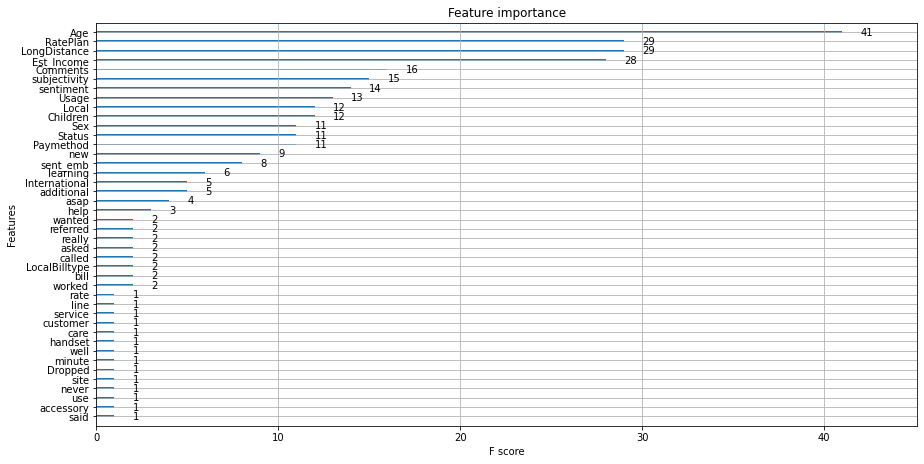

In [220]:
from xgboost import plot_importance
model_final.fit(customer_x,customer_y)
plot_importance(model_final)
plt.subplots_adjust(left=0.5, bottom=1.6, right=2.4, top=6)
plt.show()

In [222]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
y_pred = model_final.predict_proba(customer_x)
y_pred = y_pred[:,1].round()
confusion_matrix(customer_y,y_pred)

array([[ 737,   67],
       [  69, 1197]])

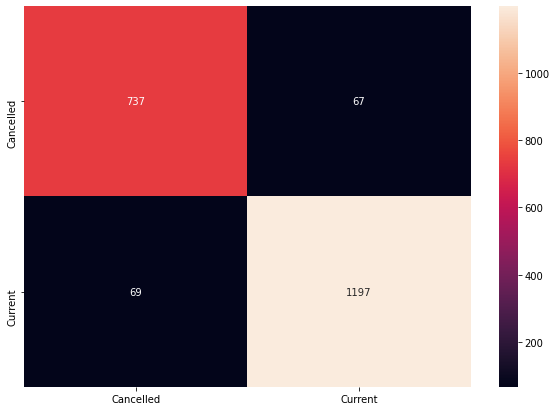

In [227]:
array = [[737,67], 
        [69,1197]]
df_cm = pd.DataFrame(array, index = ["Cancelled","Current"],
                  columns = ["Cancelled","Current"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='.4g')

In [67]:
rfcreport = pd.DataFrame({'Model':['Base Model','Model #1','Model #2','Model #3','Final Model'],
              'Combo':['rfc',"rfc+Sentiment","rfc+Sentiment+SBERT","rfc+Sentiment+SBERT+TF-IDF","Fine-tuned Model #3"],
              'Accuracy_Score':[rfcbasescore,rfcscore1,rfcscore2,rfcscore3,rfcscore4],
              'Up from Base1':[np.nan,rfcimprovement1,rfcimprovement2,rfcimprovement3,rfcimprovement4],
              "Roc_AUC_Score":[rfcbasesauc,rfcauc1,rfcauc2,rfcauc3,rfcauc4],
              "Up from Base2":[np.nan,rfcimprove_auc1,rfcimprove_auc2,rfcimprove_auc3,rfcimprove_auc4]})
rfcreport.style.background_gradient("Spectral")

,Model,Combo,Accuracy_Score,Up from Base1,Roc_AUC_Score,Up from Base2
0,Base Model,rfc,0.870538,nan,0.919057,nan
1,Model #1,rfc+Sentiment,0.888889,0.021080,0.920838,0.001939
2,Model #2,rfc+Sentiment+SBERT,0.885990,0.017751,0.926535,0.008137
3,Model #3,rfc+Sentiment+SBERT+TF-IDF,0.889372,0.021635,0.923832,0.005196
4,Final Model,Fine-tuned Model #3,0.903865,0.038283,0.928634,0.010421
